Good example (previous): 1526, x_sep=0.4, y_sep=1, interval=[0, 128, 10], scatter_size=5

In [1]:
from scripts.common.utils import load_df_pickle, idx2task, task2idx, idx2pheno, pheno2idx
from scripts.common.visualisation import MotionDrawer
from scripts.common.keypoints_format import excluded_points
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap

In [2]:
# Define input data paths
#katja df_path = "thesis_results/data/model_outputs_full_For-Skeleton-Figures.pickle"
df_path = "thesis_results/data/model_outputs_full_final.pickle"
#df_phenos_path = "thesis_results/data/model_phenos_outputs_full_For-Skeleton-Figures.pickle"
df_phenos_path = "thesis_results/data/model_phenos_outputs_full_final.pickle"

# Load dataframes from the paths
df = load_df_pickle(df_path)
df_phenos = load_df_pickle(df_phenos_path)

# Others
df["std"] =  list(-np.log(np.mean(np.std(np.stack(list(df["ori_motion"])), axis=2), axis=1)))
model_names = ["B", "B+C", "B+C+T", "B+C+T+P"]
print(df.columns)
print(df_phenos.columns)

Index(['B+C+T+P_pred_task', 'B+C+T+P_recon', 'B+C+T+P_task_latent',
       'B+C+T+P_tl_umap', 'B+C+T+P_z', 'B+C+T+P_z_umap', 'B+C+T_pred_task',
       'B+C+T_recon', 'B+C+T_task_latent', 'B+C+T_tl_umap', 'B+C+T_z',
       'B+C+T_z_umap', 'B+C_recon', 'B+C_z', 'B+C_z_umap', 'B_recon', 'B_z',
       'B_z_umap', 'direction', 'ori_motion', 'ori_motion_mask', 'pheno',
       'pheno_mask', 'task', 'task_mask', 'std'],
      dtype='object')
Index(['pheno_labels', 'pheno_latent', 'pheno_pred', 'pheno_umap'], dtype='object')


length task space:  8000


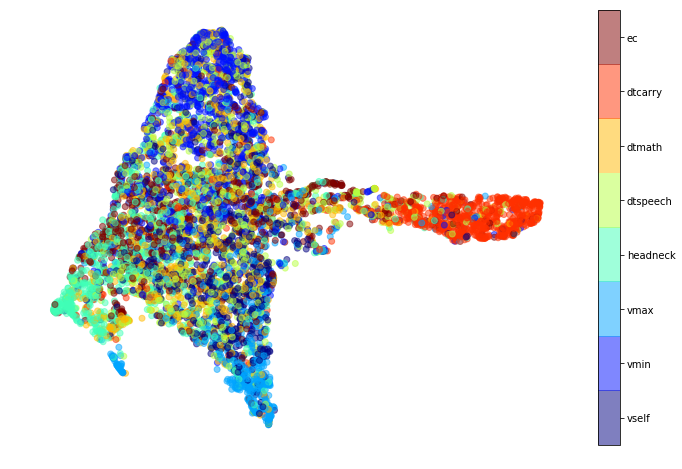

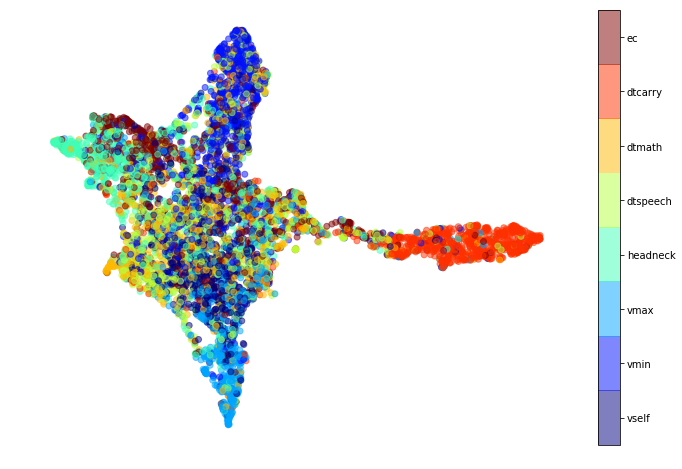

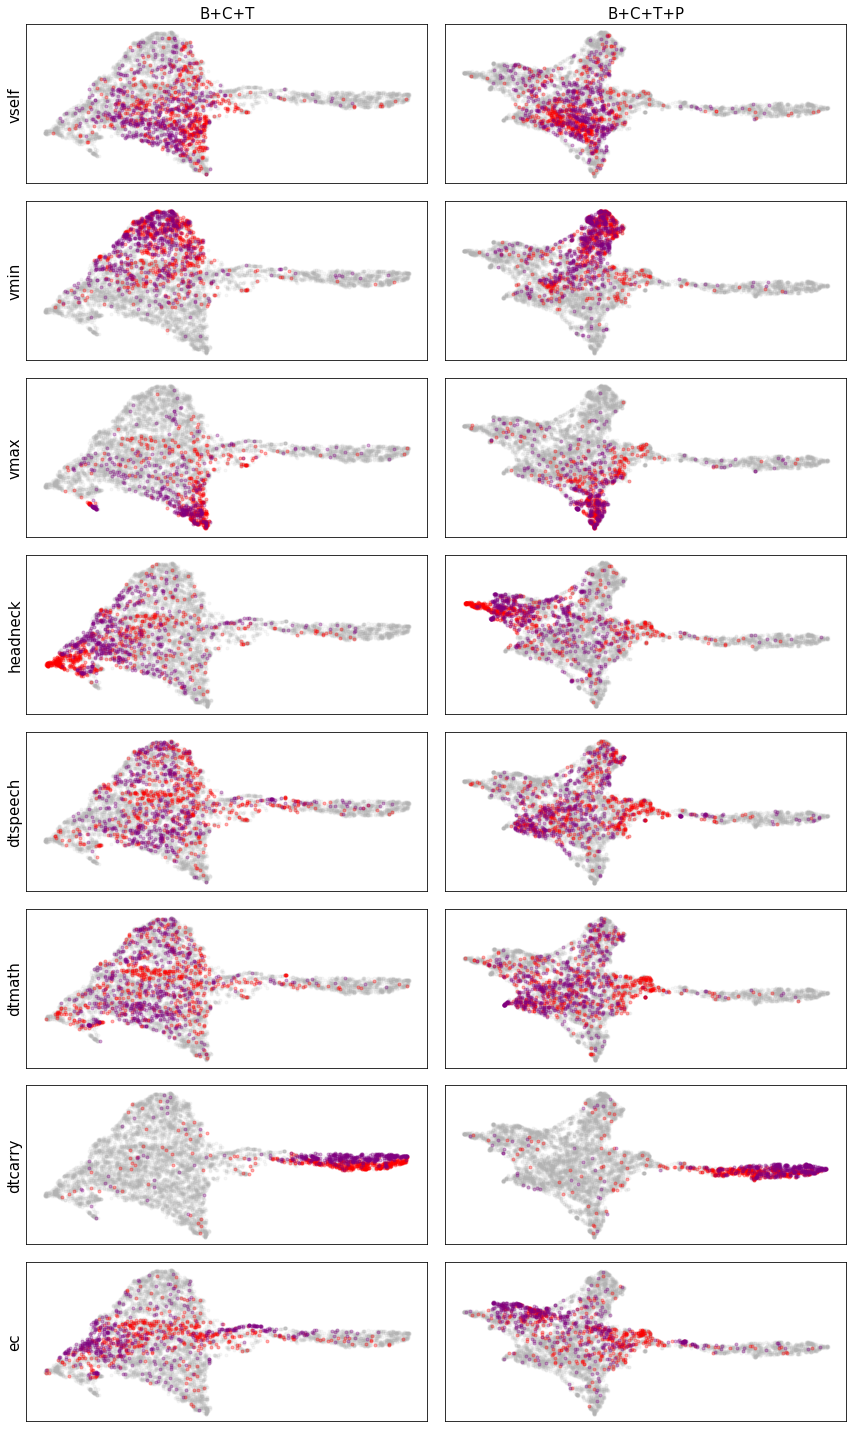

In [3]:
# TRY OUT PART BY KATJA
class TaskLatentSpaceClusterer:
    def __init__(self, df):
        self.model_names = ["B+C+T", "B+C+T+P"]
        self.df = self._filter_df(df)
        self.task = list(self.df["task"])
        self.tl_umap_dict = self._construct_tl_umap_dict()

    
    def process(self):
        self._plot_task_latent_cluster()
    
    def plot_one_model(self, model_name, mode="task", alpha=0.2):
        fig, ax = plt.subplots(figsize=(12, 8))
        if mode == "task":    
            sc = ax.scatter(self.tl_umap_dict[model_name][:, 0], self.tl_umap_dict[model_name][:, 1], c=self.task, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(8), boundaries=np.arange(9)-0.5)
            cbar.ax.set_yticklabels([idx2task(x) for x in range(8)])
        elif mode == "pheno":
            sc = ax.scatter(self.pl_umap_dict[model_name][:, 0], self.pl_umap_dict[model_name][:, 1], c=self.pheno, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(13), boundaries=np.arange(14)-0.5)
            cbar.ax.set_yticklabels([idx2pheno(x) for x in range(13)])
        save_img_path = "thesis_results/thesis_figures/{}_latent_{}.png".format(mode, model_name)
        ax.axis("off")
        plt.savefig(save_img_path, dpi=300)
        
    def _filter_df(self, df):
        mask = (df["task_mask"] == True) 
        df = df[mask]
        return df
    
    def _construct_tl_umap_dict(self):
        tl_umap_dict = dict()
        for model_name in self.model_names:
            tl_umap_dict[model_name] = np.array(list(df["{}_tl_umap".format(model_name)]))
        print('length task space: ', len(tl_umap_dict['B+C+T+P']))
        return tl_umap_dict
    
    def _plot_task_latent_cluster(self):
        fig, axes = plt.subplots(8, len(self.model_names), figsize=(12, 20))
        uni_vals, uni_counts = np.unique(self.task, return_counts=True)
        for model_idx, model_name in enumerate(self.model_names):
            for task_idx in range(8):
                # Slice z_umap
                tl_umap_focused_towards, tl_umap_focused_away, tl_umap_nonfocused = self._slice_tl_umap(model_name, self.task, task_idx)
                
                # Adaptive alpha to the sample size. Map sample [min_size, max_size] -> alpha [0.1, 0.9]
                focus_alpha = self._map_alpha(uni_vals, uni_counts, task_idx)
                
                # Scatter
                axes_one_grid = axes[task_idx, model_idx]
                axes_one_grid.scatter(x=tl_umap_nonfocused[:,0], y=tl_umap_nonfocused[:,1], c="0.7", marker=".", alpha=0.1)
                axes_one_grid.scatter(x=tl_umap_focused_towards[:,0], y=tl_umap_focused_towards[:,1], c="r", marker=".", alpha=0.3)
                axes_one_grid.scatter(x=tl_umap_focused_away[:,0], y=tl_umap_focused_away[:,1], c="purple", marker=".", alpha=0.3)
                
                # Plot labels
                if model_idx==0:
                    axes_one_grid.set_ylabel(idx2task(task_idx))
                axes_one_grid.set_xticks([]) 
                axes_one_grid.set_yticks([]) 
                if task_idx==0:
                    axes_one_grid.set_title(model_name)
        fig.tight_layout()
        save_img_path = "thesis_results/thesis_figures/task_latent_cluster_full.png"
        plt.savefig(save_img_path, dpi=100)
        
    def _slice_tl_umap(self, model_name, val_to_mask, val_idx):
        focused_mask = np.array(val_to_mask) == val_idx
        focused_towards_mask = focused_mask & (self.df["direction"] == 1)
        focused_away_mask = focused_mask & (self.df["direction"] == 2)

        # Slicing
        tl_umap_focused_towards = self.tl_umap_dict[model_name][focused_towards_mask]
        tl_umap_focused_away = self.tl_umap_dict[model_name][focused_away_mask]
        tl_umap_nonfocused = self.tl_umap_dict[model_name][focused_mask==False]
        return tl_umap_focused_towards, tl_umap_focused_away, tl_umap_nonfocused
    
    def _map_alpha(self, uni_vals, uni_counts, current_val):
        idx = np.where(uni_vals == current_val)[0][0]
        curr_count, counts_max = uni_counts[idx], np.max(uni_counts)
        alpha = 0.15 + (1 - curr_count/counts_max)*0.6
        return alpha

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)  

clusterer = TaskLatentSpaceClusterer(df)

clusterer.plot_one_model(model_name="B+C+T", 
                         mode="task",
                         alpha=0.5)

clusterer.plot_one_model(model_name="B+C+T+P", 
                         mode="task",
                         alpha=0.5)

clusterer.process()
   

[-8.715679   3.3688602]


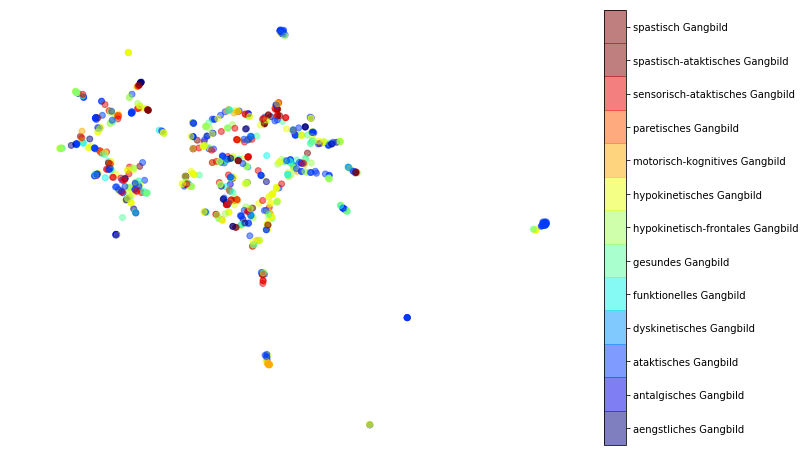

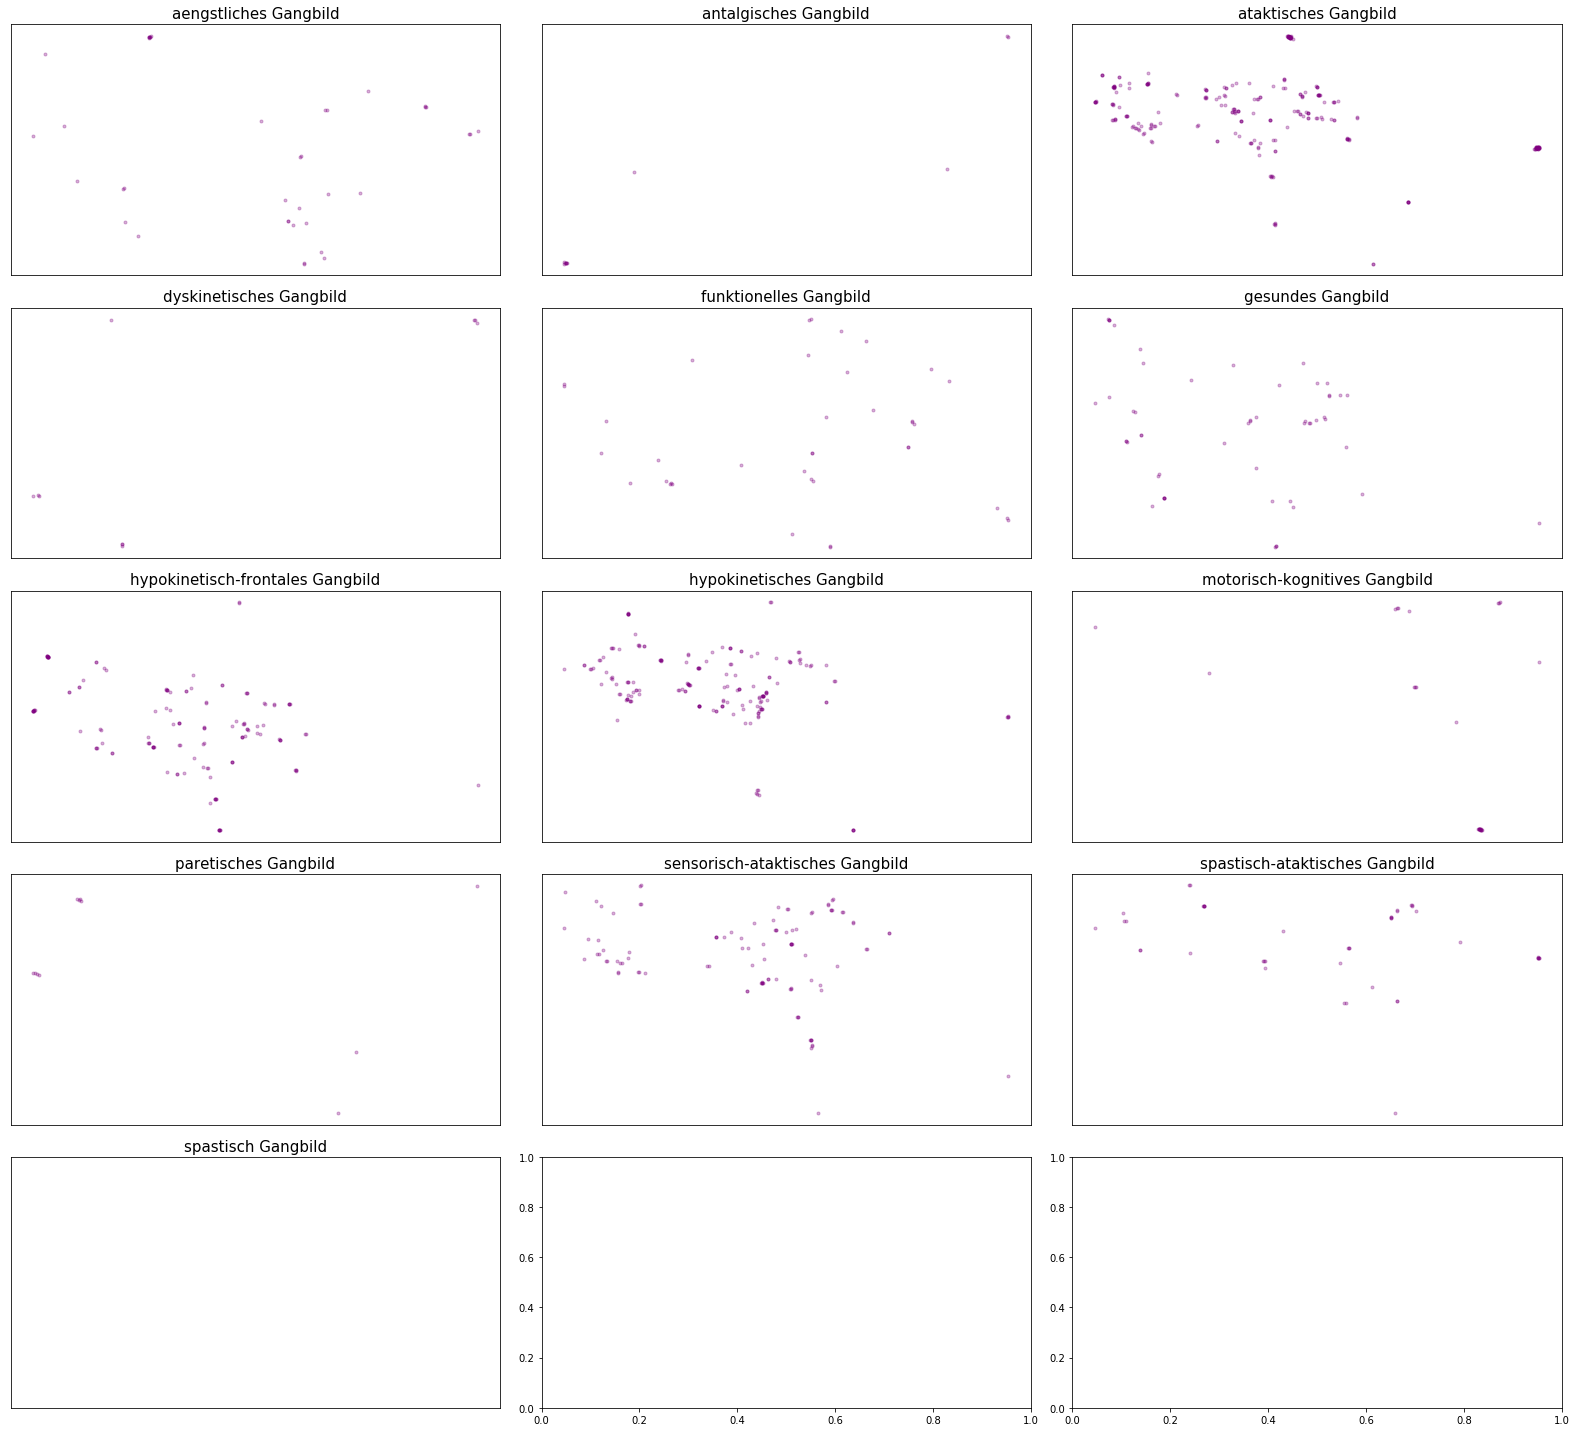

In [14]:
# TRY OUT PART BY KATJA
class PhenoLatentSpaceClusterer:
    def __init__(self, df, df_phenos):
        self.model_names = ["B+C+T+P"]
        self.df = self._filter_df(df)
        self.pheno = list(self.df["pheno"])
        self.pl_umap = self._construct_pl_umap()

    
    def process(self):
        self._plot_pheno_latent_cluster()
    
    def plot_one_model(self, model_name, mode="pheno", alpha=0.2):
        fig, ax = plt.subplots(figsize=(12, 8))
        if mode == "task":    
            sc = ax.scatter(self.tl_umap_dict[model_name][:, 0], self.tl_umap_dict[model_name][:, 1], c=self.task, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(8), boundaries=np.arange(9)-0.5)
            cbar.ax.set_yticklabels([idx2task(x) for x in range(8)])
        elif mode == "pheno":
            sc = ax.scatter(self.pl_umap[:, 0], self.pl_umap[:, 1], c=df_phenos.pheno_labels, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(13), boundaries=np.arange(14)-0.5)
            cbar.ax.set_yticklabels([idx2pheno(x) for x in range(13)])
            
        save_img_path = "thesis_results/thesis_figures/{}_latent_{}.png".format(mode, model_name)
        ax.axis("off")
        plt.savefig(save_img_path, dpi=300)
        
    def _filter_df(self, df):
        mask = (df["pheno_mask"] == True) 
        df = df[mask]
        return df
    
    def _construct_pl_umap(self):
        pl_umap = np.array(list(df_phenos["pheno_umap"]))
        print(pl_umap[12])
        return pl_umap
    
    def _plot_pheno_latent_cluster(self):
        fig, axes = plt.subplots(5, 3 * len(self.model_names), figsize=(22, 20))
        uni_vals, uni_counts = np.unique(self.pheno, return_counts=True)
        for model_idx, model_name in enumerate(self.model_names):
            for pheno_idx in range(13):
                # Slice z_umap
                pl_umap_focused_towards, pl_umap_focused_away, pl_umap_nonfocused = self._slice_pl_umap(model_name, df_phenos.pheno_labels, pheno_idx)
                
                # Adaptive alpha to the sample size. Map sample [min_size, max_size] -> alpha [0.1, 0.9]
                #focus_alpha = self._map_alpha(uni_vals, uni_counts, pheno_idx)
                focus_alpha = 0.9
                
                # Scatter
                axes_one_grid = axes[int(np.floor(pheno_idx / 3)), int(pheno_idx % 3)]
                #axes_one_grid.scatter(x=pl_umap_nonfocused[:,0], y=pl_umap_nonfocused[:,1], c="0.7", marker=".", alpha=0.1)
                #axes_one_grid.scatter(x=pl_umap_focused_towards[:,0], y=pl_umap_focused_towards[:,1], c="r", marker=".", alpha=0.3)
                axes_one_grid.scatter(x=pl_umap_focused_away[:,0], y=pl_umap_focused_away[:,1], c="purple", marker=".", alpha=0.3)
                
                # Plot labels
                if model_idx==0:
                    axes_one_grid.set_title(idx2pheno(pheno_idx))
                axes_one_grid.set_xticks([]) 
                axes_one_grid.set_yticks([]) 
        fig.tight_layout()
        save_img_path = "thesis_results/thesis_figures/pheno_latent_cluster_full.png"
        plt.savefig(save_img_path, dpi=100)
        
    def _slice_pl_umap(self, model_name, val_to_mask, val_idx):
        focused_mask = np.array(val_to_mask) == val_idx
        #focused_towards_mask = focused_mask & (self.df["direction"] == 1)
        #focused_away_mask = focused_mask & (self.df["direction"] == 2)

        # Slicing
        #pl_umap_focused_towards = self.pl_umap[focused_towards_mask]
        #pl_umap_focused_away = self.pl_umap[focused_away_mask]
        #pl_umap_nonfocused = self.pl_umap[focused_mask==False]
        
        pl_umap_nonfocused= []
        pl_umap_focused_away = self.pl_umap[focused_mask]
        pl_umap_focused_towards = []
        return pl_umap_focused_towards, pl_umap_focused_away, pl_umap_nonfocused
    
    def _map_alpha(self, uni_vals, uni_counts, current_val):
        idx = np.where(uni_vals == current_val)[0][0]
        curr_count, counts_max = uni_counts[idx], np.max(uni_counts)
        alpha = 0.15 + (1 - curr_count/counts_max)*0.6
        return alpha

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)  

clusterer = PhenoLatentSpaceClusterer(df, df_phenos)


clusterer.plot_one_model(model_name="B+C+T+P", 
                         mode="pheno",
                         alpha=0.5)

clusterer.process()

# Draw motions produced by different models (Figure 6 and 9)
This section section of code can draw static picture of a motion sequence, from different models with differemt temporal resolutions

It can reproduce Figure 6 and Figure 9 (for the motion sequence plot) in the thesis. You may need to adjust the arguments (x_sep and y_sep) of MotionDrawer class to get a correct scaling (the correct values of x_sep and y_sep were lost).


In [11]:
idx_list = [3543, 538, 1668, 1596, 3351, 3303, 5602, 5723, 3530, 478, 81, 3460]
intervals_list = [[0, 128, 10]]*8 + [[0, 128, 7]]*3
names_list = ["output_examples_3543_[0, 128, 10].png",  # For Figure 6
              "PHENO-bottom-left-atactic2_538_[0, 128, 10].png",  # This and below are all for Figure 9
              "PHENO-top-left-atactic1_1668_[0, 128, 10].png",
              "PHENO-top-left-atactic2_down_1596_[0, 128, 10].png",
              "TASK-DTcarry_3351_[0, 128, 10].png",
              "TASK-EC_3303_[0, 128, 10].png",
              "TASK-headextended_5602_[0, 128, 10].png",
              "TASK-headextended_5723_[0, 128, 10].png",
              "TASK-right-bottom-blob_3530_[0, 128, 10].png",
              "TASK-Vmax_478_[0, 128, 7].png", 
              "TASK-Vmin_81_[0, 128, 7].png",
              "TASK-Vself_3460_[0, 128, 7].png"]

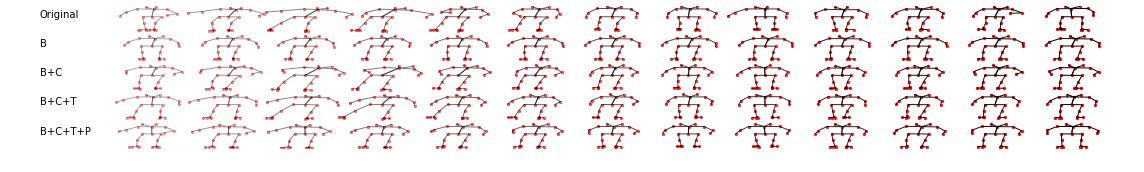

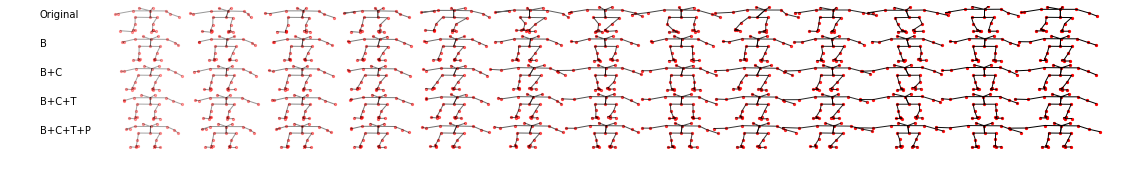

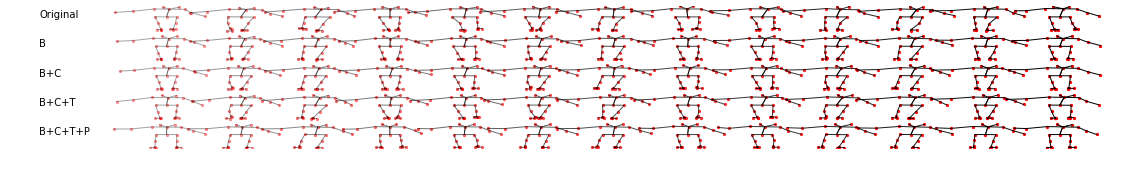

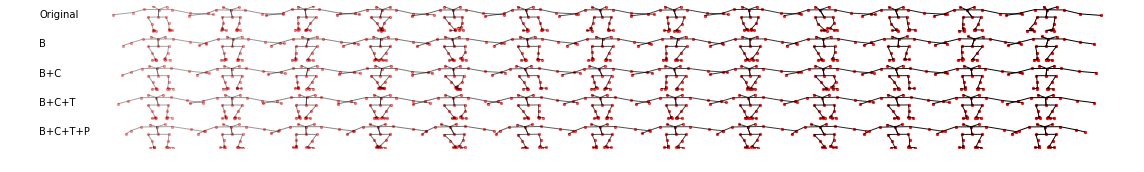

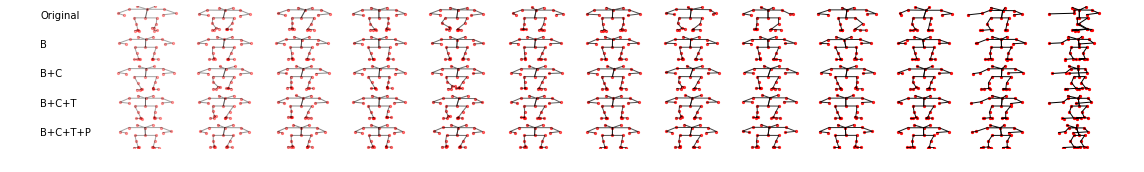

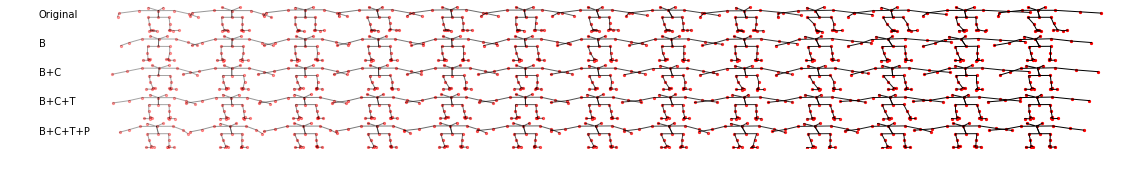

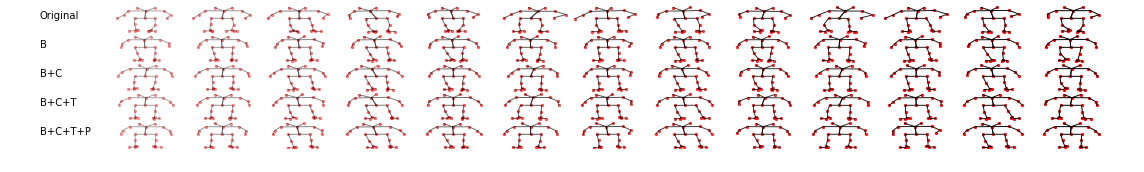

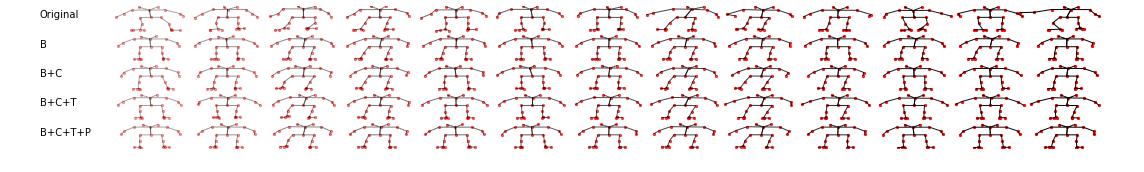

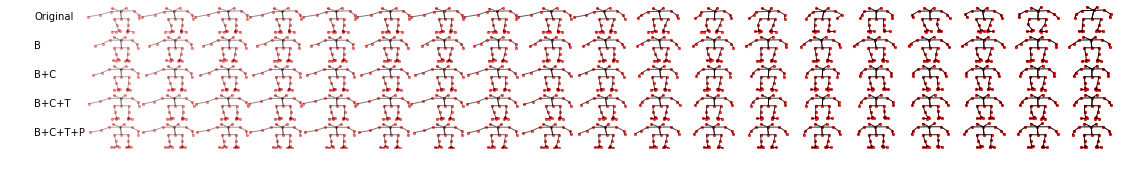

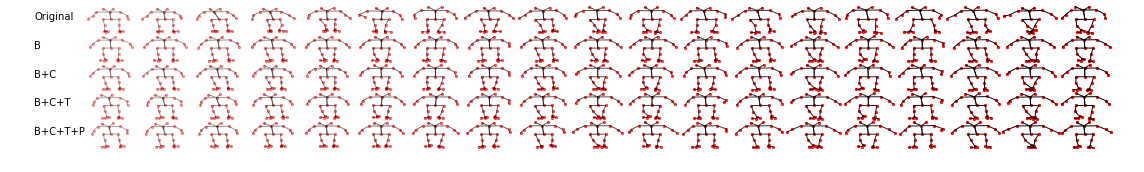

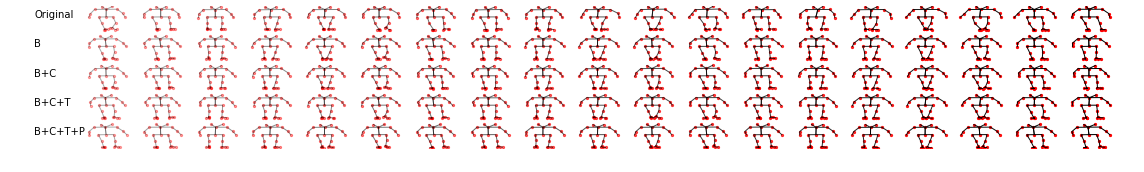

In [12]:
for selected_idx, selected_interval, save_img_name in zip(idx_list, intervals_list, names_list):
    save_img_path = "thesis_results/thesis_figures/{}".format(save_img_name)
    # save_img_path = None # uncomment this to prevent saving any figure
    
    if selected_idx == 3543:  # For figure 6 which is a comparison of 4 models
        motion_cols = ["ori_motion", "B_recon", "B+C_recon", "B+C+T_recon", "B+C+T+P_recon"]
        name_cols = ["Original", "B", "B+C", "B+C+T", "B+C+T+P"]
    #else:  # For figure 9 which only takes the final model, B+C+T+P, as example
        #motion_cols = ["B+C+T+P_recon"]
        #name_cols = ["B+C+T+P"]
    # Start Drawing
    drawer = MotionDrawer(df, motion_cols, name_cols, save_img_path, x_sep=0.4, y_sep=1, interval=selected_interval,
                      figsize=(16,2.5), scatter_size=5, dpi=300)
    ax = drawer.draw(selected_idx)



# Network validation: RMSE and Accuracies (Table 3)

The values are not exactly as the reported ones, since I have trained the models for more epochs and the quantities changed. The previous model checkpoints as in the report were already accidentally overwritten...

In [6]:
motion_cols = ["ori_motion", "B_recon", "B+C_recon", "B+C+T_recon", "B+C+T+P_recon"]
motion_cols = ["ori_motion", "B_recon", "B+C_recon", "B+C+T_recon"]

class QuantityValidator:
    def __init__(self, df, df_phenos):
        self.df = df
        self.df_phenos = df_phenos
        self.model_names = ["B", "B+C", "B+C+T", "B+C+T+P"]
        self.stats_dict = {x:[] for x in self.model_names}
        
        # Motion RMSE
        self.motion_gt = np.stack(list(self.df["ori_motion"]))
        self.motion_mask = np.stack(list(self.df["ori_motion_mask"]))
        self.motion_pred_dict = self._get_motion_preds()
        
        # Task ACC
        self.task_gt = np.stack(list(self.df["task"]))
        self.task_mask = np.stack(list(self.df["task_mask"]))
        
        # Pheno ACC
        self.pheno_gt = np.stack(list(self.df_phenos["pheno_labels"]))
        self.pheno_pred = np.stack(list(self.df_phenos["pheno_pred"]))
        
        # Reserved statistics dataframe
        self.df_stat = None
    def process(self):
        
        self._calc_all_motion_RMSE()
        self._calc_all_tasks_ACC()
        self._calc_all_pheno_ACC()
        self._create_dataframe()
    
    def _get_motion_preds(self):
        preds_dict = {x:np.stack(list(self.df["{}_recon".format(x)])) for x in self.model_names}
        return preds_dict
        
    def _calc_all_motion_RMSE(self):
        for model_name in self.model_names:
            pred = self.motion_pred_dict[model_name]
            median, lower, upper = self._calc_each_RMSE(self.motion_gt, self.motion_pred_dict[model_name], self.motion_mask)
            rmse_stat_text = "%0.4f (%0.4f-%0.4f)" % (median, lower, upper)
            self.stats_dict[model_name].append(rmse_stat_text)

    @staticmethod
    def _calc_each_RMSE(gt, pred, mask):
        sq_diff_masked = np.power(pred-gt, 2) * mask
        RMSE_all_samples = np.sqrt(np.mean(np.mean(sq_diff_masked, axis=-1), axis=-1))
        
        median, lower, upper = np.median(RMSE_all_samples), np.quantile(RMSE_all_samples, 0.25), np.quantile(RMSE_all_samples, 0.75)
        
        return median, lower, upper
    
    @staticmethod
    def _calc_each_ACC(gt, pred, mask):
        return np.mean(pred[mask] == gt[mask]) * 100
    
    def _calc_all_tasks_ACC(self):
        for model_name in self.model_names:
            if model_name in ["B+C+T", "B+C+T+P"]:
                acc = self._calc_each_ACC(gt=self.task_gt, 
                                          pred=np.stack(list(df["{}_pred_task".format(model_name)])), 
                                          mask=self.task_mask)
            else:
                acc = "N/A"
            self.stats_dict[model_name].append(acc)
    
    def _calc_all_pheno_ACC(self):
        for model_name in self.model_names:
            if model_name == "B+C+T+P":
                pheno_acc = np.mean(self.pheno_gt == self.pheno_pred) * 100
            else:
                pheno_acc = "N/A"
            self.stats_dict[model_name].append(pheno_acc)
            
    def _create_dataframe(self):
        df = pd.DataFrame(self.stats_dict, index=["Joint's RMSE", "Task ACC", "Phenotype ACC"])
        self.df_stat = df.T
        
valler = QuantityValidator(df, df_phenos)
valler.process()
print(valler.df_stat)

                   Joint's RMSE Task ACC Phenotype ACC
B        0.0141 (0.0125-0.0160)      N/A           N/A
B+C      0.0105 (0.0095-0.0120)      N/A           N/A
B+C+T    0.0113 (0.0101-0.0131)  46.9625           N/A
B+C+T+P  0.0124 (0.0110-0.0145)  50.9625       28.7406


# Latent space clustering by UMAP (Figure 7, 8 and 9)

B
False
B+C
False
B+C+T
True


KeyError: 'B'

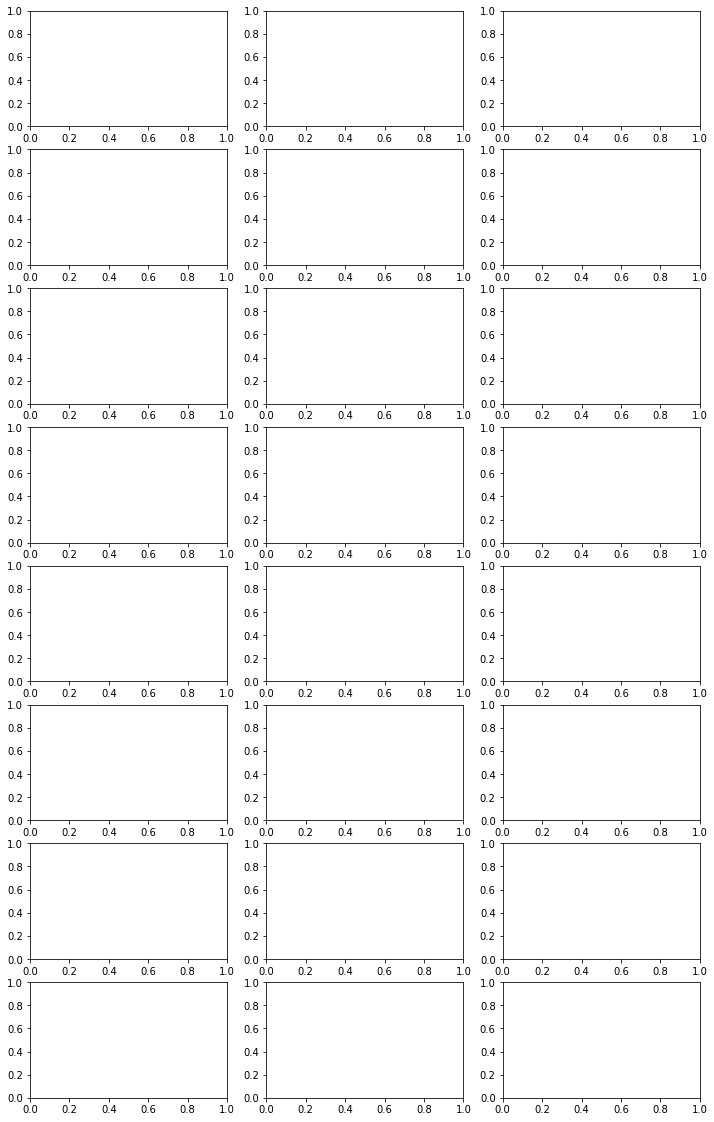

In [13]:

class LatentSpaceClusterer:
    def __init__(self, df):
        self.model_names = ["B", "B+C", "B+C+T", "B+C+T+P"]
        self.df = self._filter_df(df)
        self.task, self.pheno = np.stack(list(self.df["task"])), np.stack(list(self.df["pheno"]))
        self.z_umap_dict = self._construct_z_umap_dict()

    
    def process(self):
        self._plot_task_cluster()
        self._plot_pheno_cluster()
    
    def plot_one_model(self, model_name, mode="task", alpha=0.2):
        fig, ax = plt.subplots(figsize=(12, 8))
        if mode == "task":    
            sc = ax.scatter(self.z_umap_dict[model_name][:, 0], self.z_umap_dict[model_name][:, 1], c=self.task, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(8), boundaries=np.arange(9)-0.5)
            cbar.ax.set_yticklabels([idx2task(x) for x in range(8)])
        elif mode == "pheno":
            sc = ax.scatter(self.z_umap_dict[model_name][:, 0], self.z_umap_dict[model_name][:, 1], c=self.pheno, cmap="jet", alpha=alpha)
            cbar = plt.colorbar(sc, ticks=np.arange(13), boundaries=np.arange(14)-0.5)
            cbar.ax.set_yticklabels([idx2pheno(x) for x in range(13)])
        save_img_path = "thesis_results/thesis_figures/one_model_{}_{}.png".format(model_name, mode)
        ax.axis("off")
        plt.savefig(save_img_path, dpi=300)
        
    def _filter_df(self, df):
        mask = (df["task_mask"] == True) & (df["pheno_mask"])
        df = df[mask]
        return df
    
    # Change by katja
    def _construct_z_umap_dict(self):
        z_umap_dict = dict()
        for model_name in self.model_names:
            #df_temp2 = np.zeros((8000,2))
            #for i in range(0,8000):
            #    df_temp2[i,0] = df['{}_z'.format(model_name)][i][8]
            #    df_temp2[i,1] = df['{}_z'.format(model_name)][i][9]
            print(model_name)
            print(model_name == 'B+C+T')
            if model_name == 'B+C+T':
                z_umap_dict[model_name] = np.array(list(df["{}_tl_umap".format(model_name)]))
            #z_umap_dict[model_name] = df_temp2
        return z_umap_dict
    # End Change by katja
    
    def _plot_task_cluster(self):
        fig, axes = plt.subplots(8, len(self.model_names), figsize=(12, 20))
        uni_vals, uni_counts = np.unique(self.task, return_counts=True)
        for model_idx, model_name in enumerate(self.model_names):
            for task_idx in range(8):
                # Slice z_umap
                z_umap_focused_towards, z_umap_focused_away, z_umap_nonfocused = self._slice_z_umap(model_name, self.task, task_idx)
                
                # Adaptive alpha to the sample size. Map sample [min_size, max_size] -> alpha [0.1, 0.9]
                focus_alpha = self._map_alpha(uni_vals, uni_counts, task_idx)
                
                # Scatter
                axes_one_grid = axes[task_idx, model_idx]
                axes_one_grid.scatter(x=z_umap_nonfocused[:,0], y=z_umap_nonfocused[:,1], c="0.7", marker=".", alpha=0.1)
                axes_one_grid.scatter(x=z_umap_focused_towards[:,0], y=z_umap_focused_towards[:,1], c="r", marker=".", alpha=0.3)
                axes_one_grid.scatter(x=z_umap_focused_away[:,0], y=z_umap_focused_away[:,1], c="purple", marker=".", alpha=0.3)
                
                # Plot labels
                if model_idx==0:
                    axes_one_grid.set_ylabel(idx2task(task_idx))
                axes_one_grid.set_xticks([]) 
                axes_one_grid.set_yticks([]) 
                if task_idx==0:
                    axes_one_grid.set_title(model_name)
        fig.tight_layout()
        save_img_path = "thesis_results/thesis_figures/task_cluster_full.png"
        plt.savefig(save_img_path, dpi=100)
    
    def _plot_pheno_cluster(self):
        fig, axes = plt.subplots(13, len(self.model_names), figsize=(12, 32))
        uni_vals, uni_counts = np.unique(self.pheno, return_counts=True)
        for model_idx, model_name in enumerate(self.model_names):
            for pheno_idx in range(13):
                # Slice z_umap
                z_umap_focused_towards, z_umap_focused_away, z_umap_nonfocused = self._slice_z_umap(model_name, self.pheno, pheno_idx)
                
                # Adaptive alpha to the sample size. Map sample [min_size, max_size] -> alpha [0.1, 0.9]
                focus_alpha = self._map_alpha(uni_vals, uni_counts, pheno_idx)
                
                # Scatter
                axes_one_grid = axes[pheno_idx, model_idx]
                axes_one_grid.scatter(x=z_umap_nonfocused[:,0], y=z_umap_nonfocused[:,1], c="0.7", marker=".", alpha=0.1)
                axes_one_grid.scatter(x=z_umap_focused_towards[:,0], y=z_umap_focused_towards[:,1], c="r", marker=".", alpha=focus_alpha)
                axes_one_grid.scatter(x=z_umap_focused_away[:,0], y=z_umap_focused_away[:,1], c="purple", marker=".", alpha=focus_alpha)
                
                # Plot labels
                if model_idx==0:
                    axes_one_grid.set_ylabel(idx2pheno(pheno_idx))
                axes_one_grid.set_xticks([]) 
                axes_one_grid.set_yticks([]) 
                if pheno_idx==0:
                    axes_one_grid.set_title(model_name)
        fig.tight_layout()
        save_img_path = "thesis_results/thesis_figures/pheno_cluster_full.png"
        plt.savefig(save_img_path, dpi=300)
        
    def _slice_z_umap(self, model_name, val_to_mask, val_idx):
        focused_mask = val_to_mask == val_idx
        focused_towards_mask = focused_mask & (self.df["direction"] == 1)
        focused_away_mask = focused_mask & (self.df["direction"] == 2)

        # Slicing
        z_umap_focused_towards = self.z_umap_dict[model_name][focused_towards_mask]
        z_umap_focused_away = self.z_umap_dict[model_name][focused_away_mask]
        z_umap_nonfocused = self.z_umap_dict[model_name][focused_mask==False]
        return z_umap_focused_towards, z_umap_focused_away, z_umap_nonfocused
    
    def _map_alpha(self, uni_vals, uni_counts, current_val):
        idx = np.where(uni_vals == current_val)[0][0]
        curr_count, counts_max = uni_counts[idx], np.max(uni_counts)
        alpha = 0.15 + (1 - curr_count/counts_max)*0.6
        return alpha

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)  

clusterer = LatentSpaceClusterer(df)
# Plot Figure 7 and 8
clusterer.process()
# Plot the two clusters (for tasks and phenotypes) in Figure 9
clusterer.plot_one_model(model_name="B+C+T+P", 
                         mode="task",
                        alpha=0.5)
clusterer.plot_one_model(model_name="B+C+T+P", 
                         mode="pheno",
                        alpha=0.5)

# Interactive Plot for exploration

In [7]:
df_temp2 = np.zeros((8000,2))
for i in range(0,8000):
    df_temp2[i,0] = df['B+C_z'][i][0]
    df_temp2[i,1] = df['B+C_z'][i][1]

print(df_temp2.shape)

(8000, 2)


In [8]:
import plotly.graph_objs as go
from glob import glob
from ipywidgets import Video, Layout, VBox, HBox, HTML, widgets, interactive
from scripts.common.utils import idx2direction, tick_val_text_tasks, tick_val_text_phenos, tick_val_text_directions, task2idx, pheno2idx, direction2idx

In [9]:
df["task_text"] = df.task.apply(idx2task)
df["pheno_text"] = df.pheno.apply(idx2pheno)
df["direction_text"] = df.direction.apply(idx2direction)

In [10]:

class InteractivePlotter:
    def __init__(self, df):
        self.df = df
        self.curr_model_name = "B"
        self.curr_type = "task"  # task, pheno, direction, std
        self.display_cols = ["task", "pheno", "pheno_mask", "direction", "std"]
        self._initialize_widgets()
        
    def _initialize_widgets(self):
        # Display table
        self.display_table = HTML(value = self.df[self.display_cols].iloc[0].to_frame().to_html())
        
        # Image widget
        self.imgs_dict = dict()
        for i in range(self.df.shape[0]):
            with open("thesis_results/recon_videos/final_{}.mp4".format(i), "rb") as fh:
                image = fh.read()
                self.imgs_dict[i] = image
        self.img_widget = Video(
            value=self.imgs_dict[0],
            layout=Layout(height='300px', width='800px')
        )
        
        # model menu
        self.model_menu = widgets.Dropdown(
            options=model_names,
            value=self.curr_model_name[0],
            description="Models:",
        )
        
        # plot type menu
        self.type_menu = widgets.Dropdown(
            options=["task", "pheno", "direction", "std"],
            value="task",
            description="Types:",
        )
        
        # focus label menu
        self.focus_label_menu = widgets.Dropdown(
            options=["ALL"] + tick_val_text_tasks()[1],
            value="ALL",
            description="Label focus:",
        )
        
        # Opacity slider
        self.opacity_slider = interactive(
            self._set_opacity,
            focus_opacity=(0.0, 1.0, 0.01),
            nonfocus_opacity=(0.0, 1.0, 0.01),
            focus_std=(df["std"].min(), df["std"].max(), 0.01)
        )
        
        
        # Scatter plot
        self.fig = go.FigureWidget(
            data=[
                dict(
                    type='scattergl',
                    x=np.array(list(self.df["{}_z_umap".format(self.curr_model_name)]))[:,0],
                    y=np.array(list(self.df["{}_z_umap".format(self.curr_model_name)]))[:,1],
                    mode='markers',
                )
            ],
        )
        self.fig.layout.titlefont.size = 12
        self.fig.layout.xaxis.title = "x"
        self.fig.layout.yaxis.title = "y"
        self.fig.layout.autosize = False
        self.fig.layout.width, self.fig.layout.height = 600, 600
        self.fig.layout.hovermode = 'closest'
        self.scatter = self.fig.data[0]
        self.scatter.hoverinfo = "text"
        self._scatter_plot_type("task")
        self.scatter.marker.size = 8
        
        self.scatter.on_hover(self._hover_fn)
        self.model_menu.observe(self._model_menu_response, names="value")
        self.type_menu.observe(self._type_menu_response, names="value")
        self.focus_label_menu.observe(self._focus_label_menu_response, names="value")
        
        layer_bottom = self.img_widget
        layer_top = HBox([self.fig, VBox([self.model_menu, self.type_menu, self.focus_label_menu, self.opacity_slider, self.display_table])])
        self.widget_all = VBox([layer_top, layer_bottom])
        
    def _scatter_plot_type(self, plot_type):
        color_scale = "Jet"
        if plot_type == "task":
            target_text = self.df["task_text"]
            target_tickvals, target_ticktext = tick_val_text_tasks()[0], tick_val_text_tasks()[1]
            target_color = self.df["task"]
        elif plot_type == "pheno":
            target_text = self.df["pheno_text"]
            target_tickvals, target_ticktext = tick_val_text_phenos()[0], tick_val_text_phenos()[1]
            target_color = self.df["pheno"]
        elif plot_type == "direction":
            target_text = self.df["direction_text"]
            target_tickvals, target_ticktext = tick_val_text_directions()[0], tick_val_text_directions()[1]
            target_color = self.df["direction"]
        elif plot_type == "std":
            target_text = self.df["std"]
            target_tickvals, target_ticktext = [df["std"].min(), df["std"].max()], [df["std"].min(), df["std"].max()]
            target_color = self.df["std"]
            color_scale = "RdBu"
        self.scatter.text = target_text
        self.scatter.marker.color = target_color
        self.scatter.marker.colorbar = dict(
            title = plot_type,
            tickvals = target_tickvals,
            ticktext = target_ticktext,
            ticks = 'outside'
        )
        self.scatter.marker.colorscale = color_scale
    
    def _model_menu_response(self, change):
        self.curr_model_name = self.model_menu.value
        self.scatter.x = np.array(list(self.df["{}_z_umap".format(self.curr_model_name)]))[:,0]
        self.scatter.y = np.array(list(self.df["{}_z_umap".format(self.curr_model_name)]))[:,1]
        self.fig.show()
    
    def _type_menu_response(self, change):
        self._scatter_plot_type(self.type_menu.value)
        
        if self.type_menu.value == "task":
            self.focus_label_menu.options = ["ALL"] + tick_val_text_tasks()[1]
            self.focus_label_menu.value = "ALL"
        if self.type_menu.value == "pheno":
            self.focus_label_menu.options = ["ALL"] + tick_val_text_phenos()[1]
            self.focus_label_menu.value = "ALL"
        if self.type_menu.value == "direction":
            self.focus_label_menu.options = ["ALL"] + tick_val_text_directions()[1]
            self.focus_label_menu.value = "ALL"
        if self.type_menu.value == "std":
            pass
        
        
    def _hover_fn(self, trace, points, state):
        
        # Fetch the hovered point
        ind = points.point_inds[0]

        # Update entry in shown dataframe
        self.display_table.value = self.df[self.display_cols].iloc[ind].to_frame().to_html()
        
        # Update image display
        self.img_widget.value = self.imgs_dict[ind]
    
    def _focus_label_menu_response(self, change):
        self._set_relevant_opacity(
            self.opacity_slider.children[0].value,
            self.opacity_slider.children[1].value,
            self.opacity_slider.children[2].value
        )
    
    def _set_opacity(self, focus_opacity, nonfocus_opacity, focus_std):
        self._set_relevant_opacity(
            focus_opacity,
            nonfocus_opacity,
            focus_std
        )
    
    def _set_relevant_opacity(self, focus_opacity, nonfocus_opacity, focus_std):
        alphas = np.zeros(df.shape[0])
        if self.type_menu.value == "task":
            if self.focus_label_menu.value == "ALL":
                alphas[:] = focus_opacity
            else:
                task_index = task2idx(self.focus_label_menu.value)
                alphas[df["task"]==task_index] = focus_opacity
                alphas[df["task"]!=task_index] = nonfocus_opacity        
        elif self.type_menu.value == "pheno":
            if self.focus_label_menu.value == "ALL":
                alphas[:] = focus_opacity
            else:
                pheno_index = pheno2idx(self.focus_label_menu.value)
                alphas[df["pheno"]==pheno_index] = focus_opacity
                alphas[df["pheno"]!=pheno_index] = nonfocus_opacity
        elif self.type_menu.value == "direction":
            if self.focus_label_menu.value == "ALL":
                alphas[:] = focus_opacity
            else:
                direction_index = direction2idx[focus_label]
                alphas[df["direction"]==direction_index] = focus_opacity
                alphas[df["direction"]!=direction_index] = nonfocus_opacity
        elif self.type_menu.value == "std":
                mask = (df["std"] > focus_std - 0.02) & (df["std"] < focus_std + 0.02) 
                alphas[mask] = focus_opacity
                alphas[mask == False] = nonfocus_opacity

        self.scatter.marker.opacity = alphas

In [11]:
video_paths = glob("thesis_results/recon_videos/*.mp4")
num_vids = len(video_paths)
print("Number of available videos = {}, only first {}/8000 test set samples are plotted".format(num_vids, num_vids))
ipter = InteractivePlotter(df.iloc[0:num_vids])
ipter.widget_all

Number of available videos = 8000, only first 8000/8000 test set samples are plotted


    'data': [{'hoverinfo': 'text',
              'marker': {'colo…